In [1]:
#importing Libraries
import os
import time
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
from icecream import ic
import tensorflow as tf
from scipy.stats import skew
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import tensorflow.keras.backend as K
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from dhs_modelling_functions_new import final_ds_droping_cols, fold_generator

2025-05-29 10:55:21.702771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#setting up random seeds for reproducibility
tf.random.set_seed(6688)
random.seed(6688)
np.random.seed(6688)

In [3]:
dataset_type = 'HR' 
urban_rural_all_mode = 'all'
group_by_col = 'adm2_gaul'
# More Options
drop_agriculture = False

input_dir= "/home/myuser/data/preprocessed_data/DHS_n_more/"
in_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

In [4]:
input_df = pd.read_pickle(in_f)
# input_df = pd.read_csv("/home/myuser/prj/code/clustering/5_grouped_df_V3_HR_adm2_gaul_joined_with_ipc_all.csv")

df = final_ds_droping_cols(input_df, drop_meta=True, drop_food_help=True, drop_perc=40,
                           retain_month=False, drop_highly_correlated_cols=False, drop_region=True, 
                 drop_data_sets=['Meta one-hot encoding', 'Meta frequency encoding'], 
                 use_NAN_amount_and_replace_NANs_in_categorical=False, drop_agricultural_cols=drop_agriculture, 
                 drop_below_version=False, numerical_data=['mean'], retain_adm=False, 
                 retain_GEID_init=False, verbose=3)

drop_cols = [c for c in df.columns if 'FS;' in c and not '0-2y' in c]
# df = df.drop(columns=drop_cols)
df.drop(columns=drop_cols, inplace=True, errors='ignore')
df.drop('DHS Cat; translator used: not at all', axis=1, inplace= True)
df.drop('DHS Cat; translator used: yes', axis=1, inplace= True)

Dropped Meta one-hot encoding; data: ['Meta one-hot encoding; adm0_gaul: Angola', 'Meta one-hot encoding; adm0_gaul: Benin', 'Meta one-hot encoding; adm0_gaul: Burkina Faso', 'Meta one-hot encoding; adm0_gaul: Burundi', 'Meta one-hot encoding; adm0_gaul: Cameroon', 'Meta one-hot encoding; adm0_gaul: Central African Republic', 'Meta one-hot encoding; adm0_gaul: Chad', 'Meta one-hot encoding; adm0_gaul: Comoros', "Meta one-hot encoding; adm0_gaul: Côte d'Ivoire", 'Meta one-hot encoding; adm0_gaul: Democratic Republic of the Congo', 'Meta one-hot encoding; adm0_gaul: Egypt', 'Meta one-hot encoding; adm0_gaul: Ethiopia', 'Meta one-hot encoding; adm0_gaul: Gabon', 'Meta one-hot encoding; adm0_gaul: Gambia', 'Meta one-hot encoding; adm0_gaul: Ghana', 'Meta one-hot encoding; adm0_gaul: Guinea', 'Meta one-hot encoding; adm0_gaul: Kenya', 'Meta one-hot encoding; adm0_gaul: Lesotho', 'Meta one-hot encoding; adm0_gaul: Liberia', 'Meta one-hot encoding; adm0_gaul: Madagascar', 'Meta one-hot encodi

In [5]:
# countries to drop
countries_to_drop = ['Egypt',  'Central African Republic', 'Comoros'] 

# dropping rows where 'Meta; adm0_gaul' is in the drop list
df_filtered = df[~df['Meta; adm0_gaul'].isin(countries_to_drop)]

# new shape
print("New shape after dropping specified countries:", df_filtered.shape)

New shape after dropping specified countries: (13723, 98)


In [6]:
# only keeping: numerical_only and it has missisng values!
numerical_only = df_filtered.select_dtypes(include=[np.number])
numerical_only.shape

(13723, 96)

In [7]:
# applying KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df1_imputed = pd.DataFrame(imputer.fit_transform(numerical_only), columns=numerical_only.columns)

# elbow method

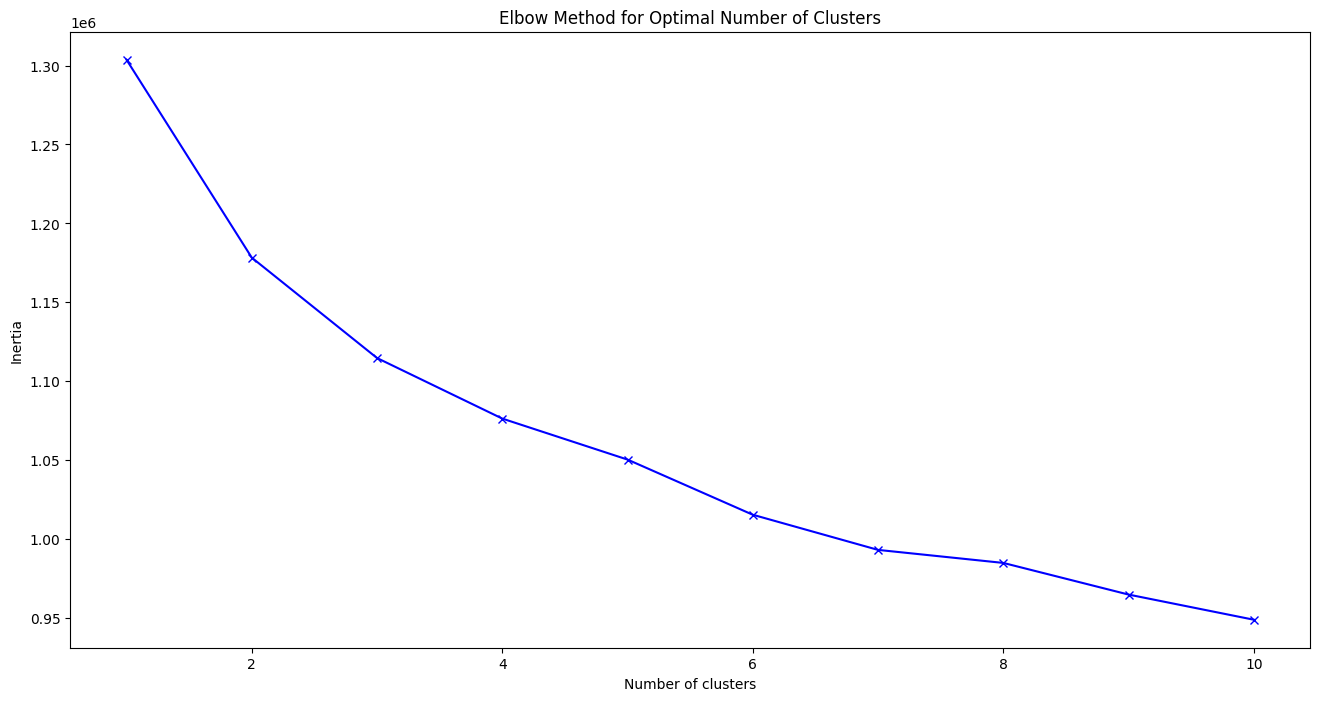

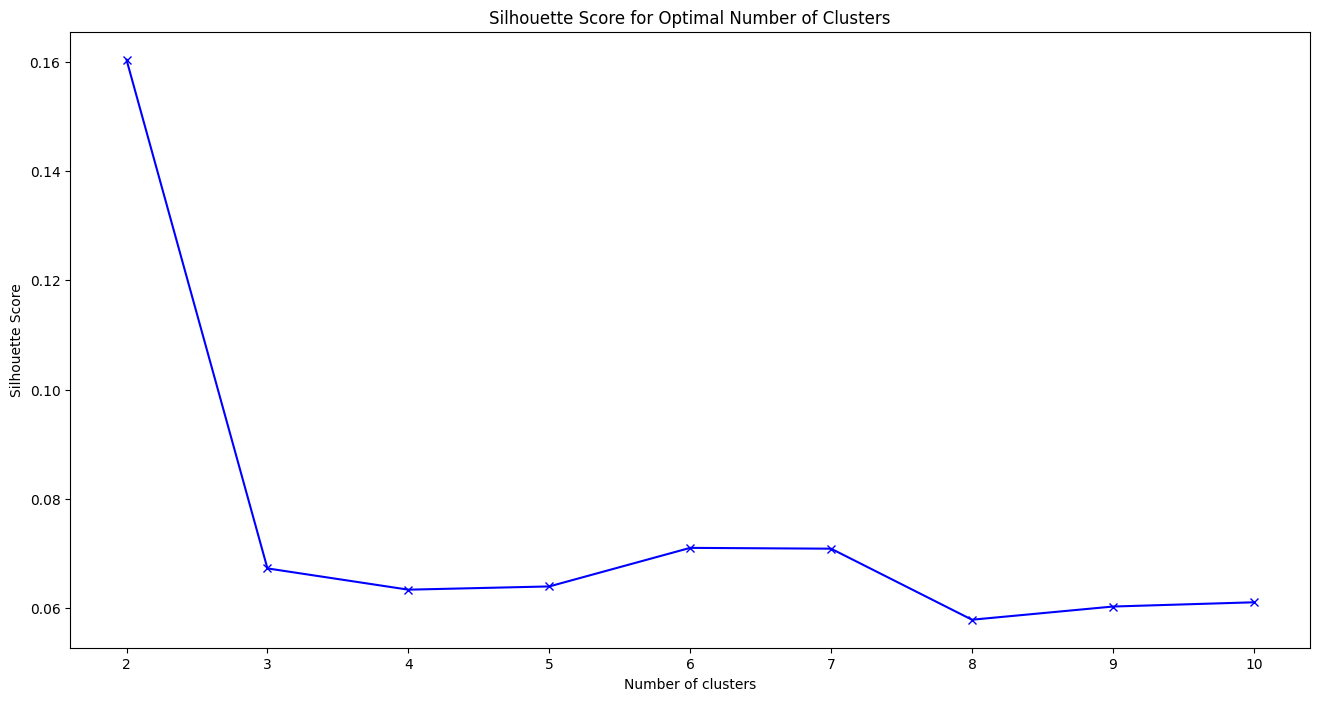

In [8]:
save_dir=  "/home/myuser/prj/code/clustering/" 

# standardize the data
scaler = StandardScaler()
# scaled_df = scaler.fit_transform(knn_imputed_original_df)
scaled_df = scaler.fit_transform(df1_imputed)

# elbow Method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(16, 8))
plt.plot(range(2, 11), silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.savefig(f"{save_dir}/elbow_method_2000.png")
plt.show()

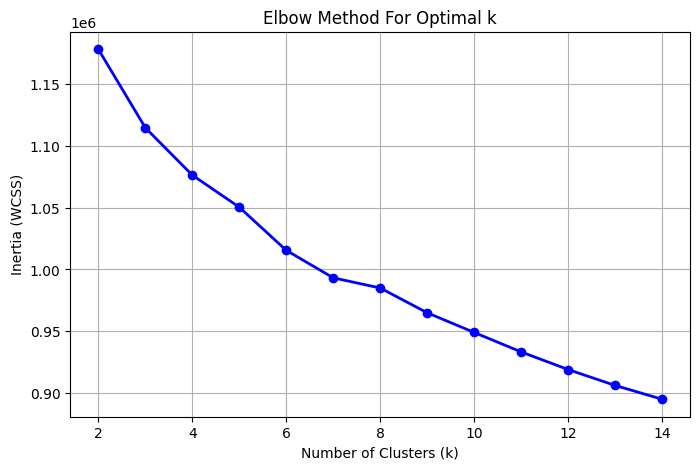

In [9]:
inertia = []
K = range(2, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_df)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

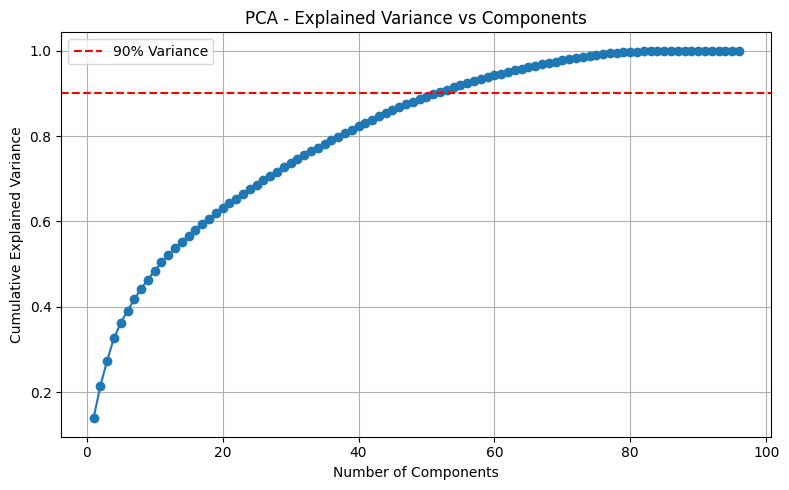

In [10]:
pca = PCA()
pca.fit(scaled_df)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Silhouette Score
The silhouette score measures the similarity of a data point to its own cluster compared to other clusters. It ranges from -1 to 1.
Interpretation:
A silhouette score close to +1 indicates that the data point is well-clustered and far from neighboring clusters.
A score close to 0 indicates that the data point is on or very close to the decision boundary between two neighboring clusters.
A score close to -1 indicates that the data point might have been assigned to the wrong cluster.
In your output, the silhouette score is 0.5610368241295314, which is relatively high and indicates that the clusters are well-defined and the data points are well-clustered.

## Inertia (Within-cluster sum of squares)
Inertia is the sum of squared distances from each data point to its assigned cluster center. It measures how tightly the clusters are packed.
Interpretation:
Lower values of inertia indicate that data points are closer to their respective cluster centers, suggesting better clustering.
The inertia value itself is dependent on the scale of the data and the number of data points, so it is not directly comparable across different datasets or clustering configurations.
In your output, the inertia value is 86656339.33859646, which is specific to your dataset and scale.

# tsne plot

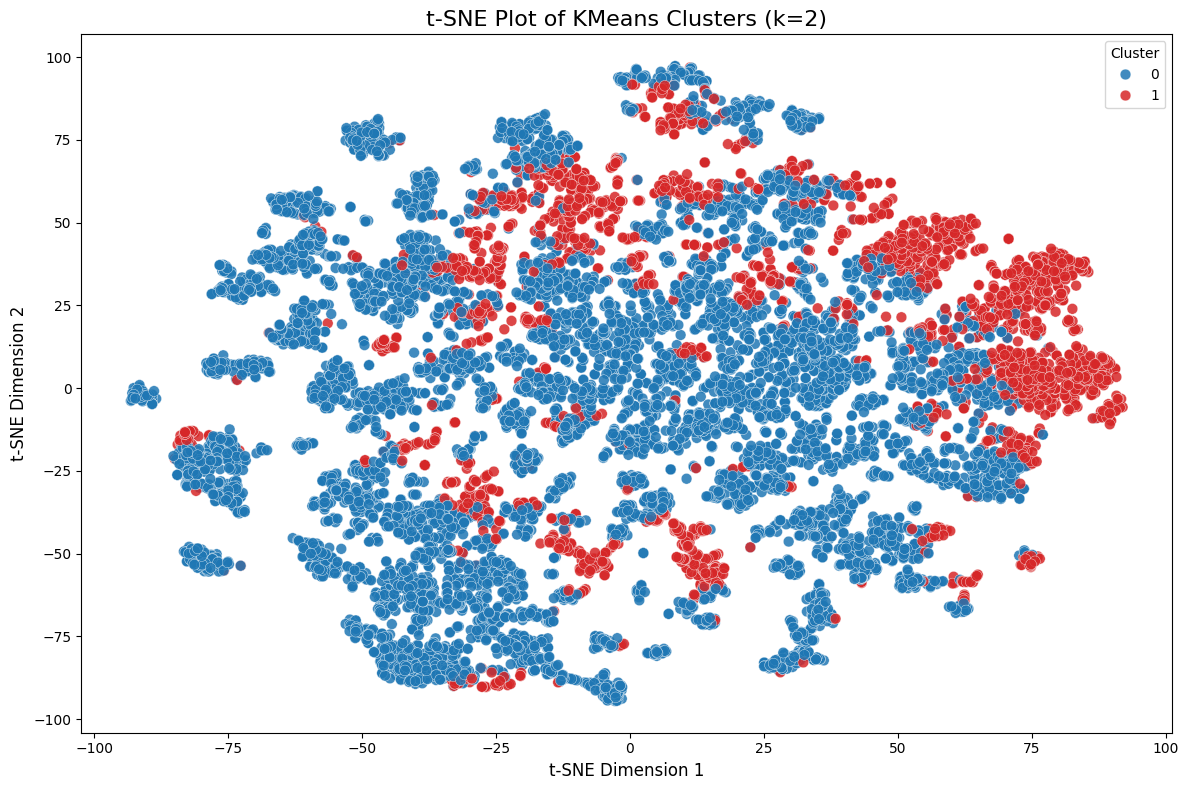

In [17]:
# KMeans on SCALED data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_df) 

# cluster labels back to the UNscaled, KNN-imputed DataFrame
df1_imputed['cluster'] = kmeans.labels_ 

# applying t-SNE for visualization 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_df)

# storing t-SNE results in unscaled (but KNN-imputed) df for plotting
df1_imputed['tsne-2d-one'] = tsne_results[:, 0]
df1_imputed['tsne-2d-two'] = tsne_results[:, 1]

# color palette — only need 0 and 1 for 2 clusters
palette = {
    0: '#1f77b4',  # blue
    1: '#d62728'   # red
}

# plot with seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='cluster',
    palette=palette, 
    data=df1_imputed,
    alpha=0.85,
    edgecolor='white',
    linewidth=0.3,
    s=60
)
plt.title('t-SNE Plot of KMeans Clusters (k=2)', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.savefig(f"{save_dir}/tsne_plot_k2_thesis.png", dpi=300)
plt.show()

In [13]:
# Silhouette Score (1 means perfect clustering, -1 indicates incorrect clustering)
silhouette_avg = silhouette_score(scaled_df, kmeans.labels_)

# Davies-Bouldin Index (lower values indicate better clustering)
davies_bouldin = davies_bouldin_score(scaled_df, kmeans.labels_)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.16040159539038995
Davies-Bouldin Index: 2.632089961731211


# Feature Importance: k-Means Clustering with Barplot

Feature importance based on k-Means clustering:
                                                    Importance
DHS Cat; has television: yes                          0.927779
DHS Cat; has electricity: yes                         0.880503
DHS Cat; has refrigerator: yes                        0.859766
DHS Cat; type of place of residence: rural            0.749604
DHS Cat; URBAN_RURA: R                                0.747992
...                                                        ...
DHS Cat; water usually treated by: solar disinf...    0.033645
DHS Cat; water usually treated by: strain throu...    0.027183
DHS Num; number of rooms used for sleeping: mean      0.020244
DHS Cat; source of drinking water: tube well or...    0.018406
DHS Cat; type of toilet facility: traditional b...    0.000000

[96 rows x 1 columns]


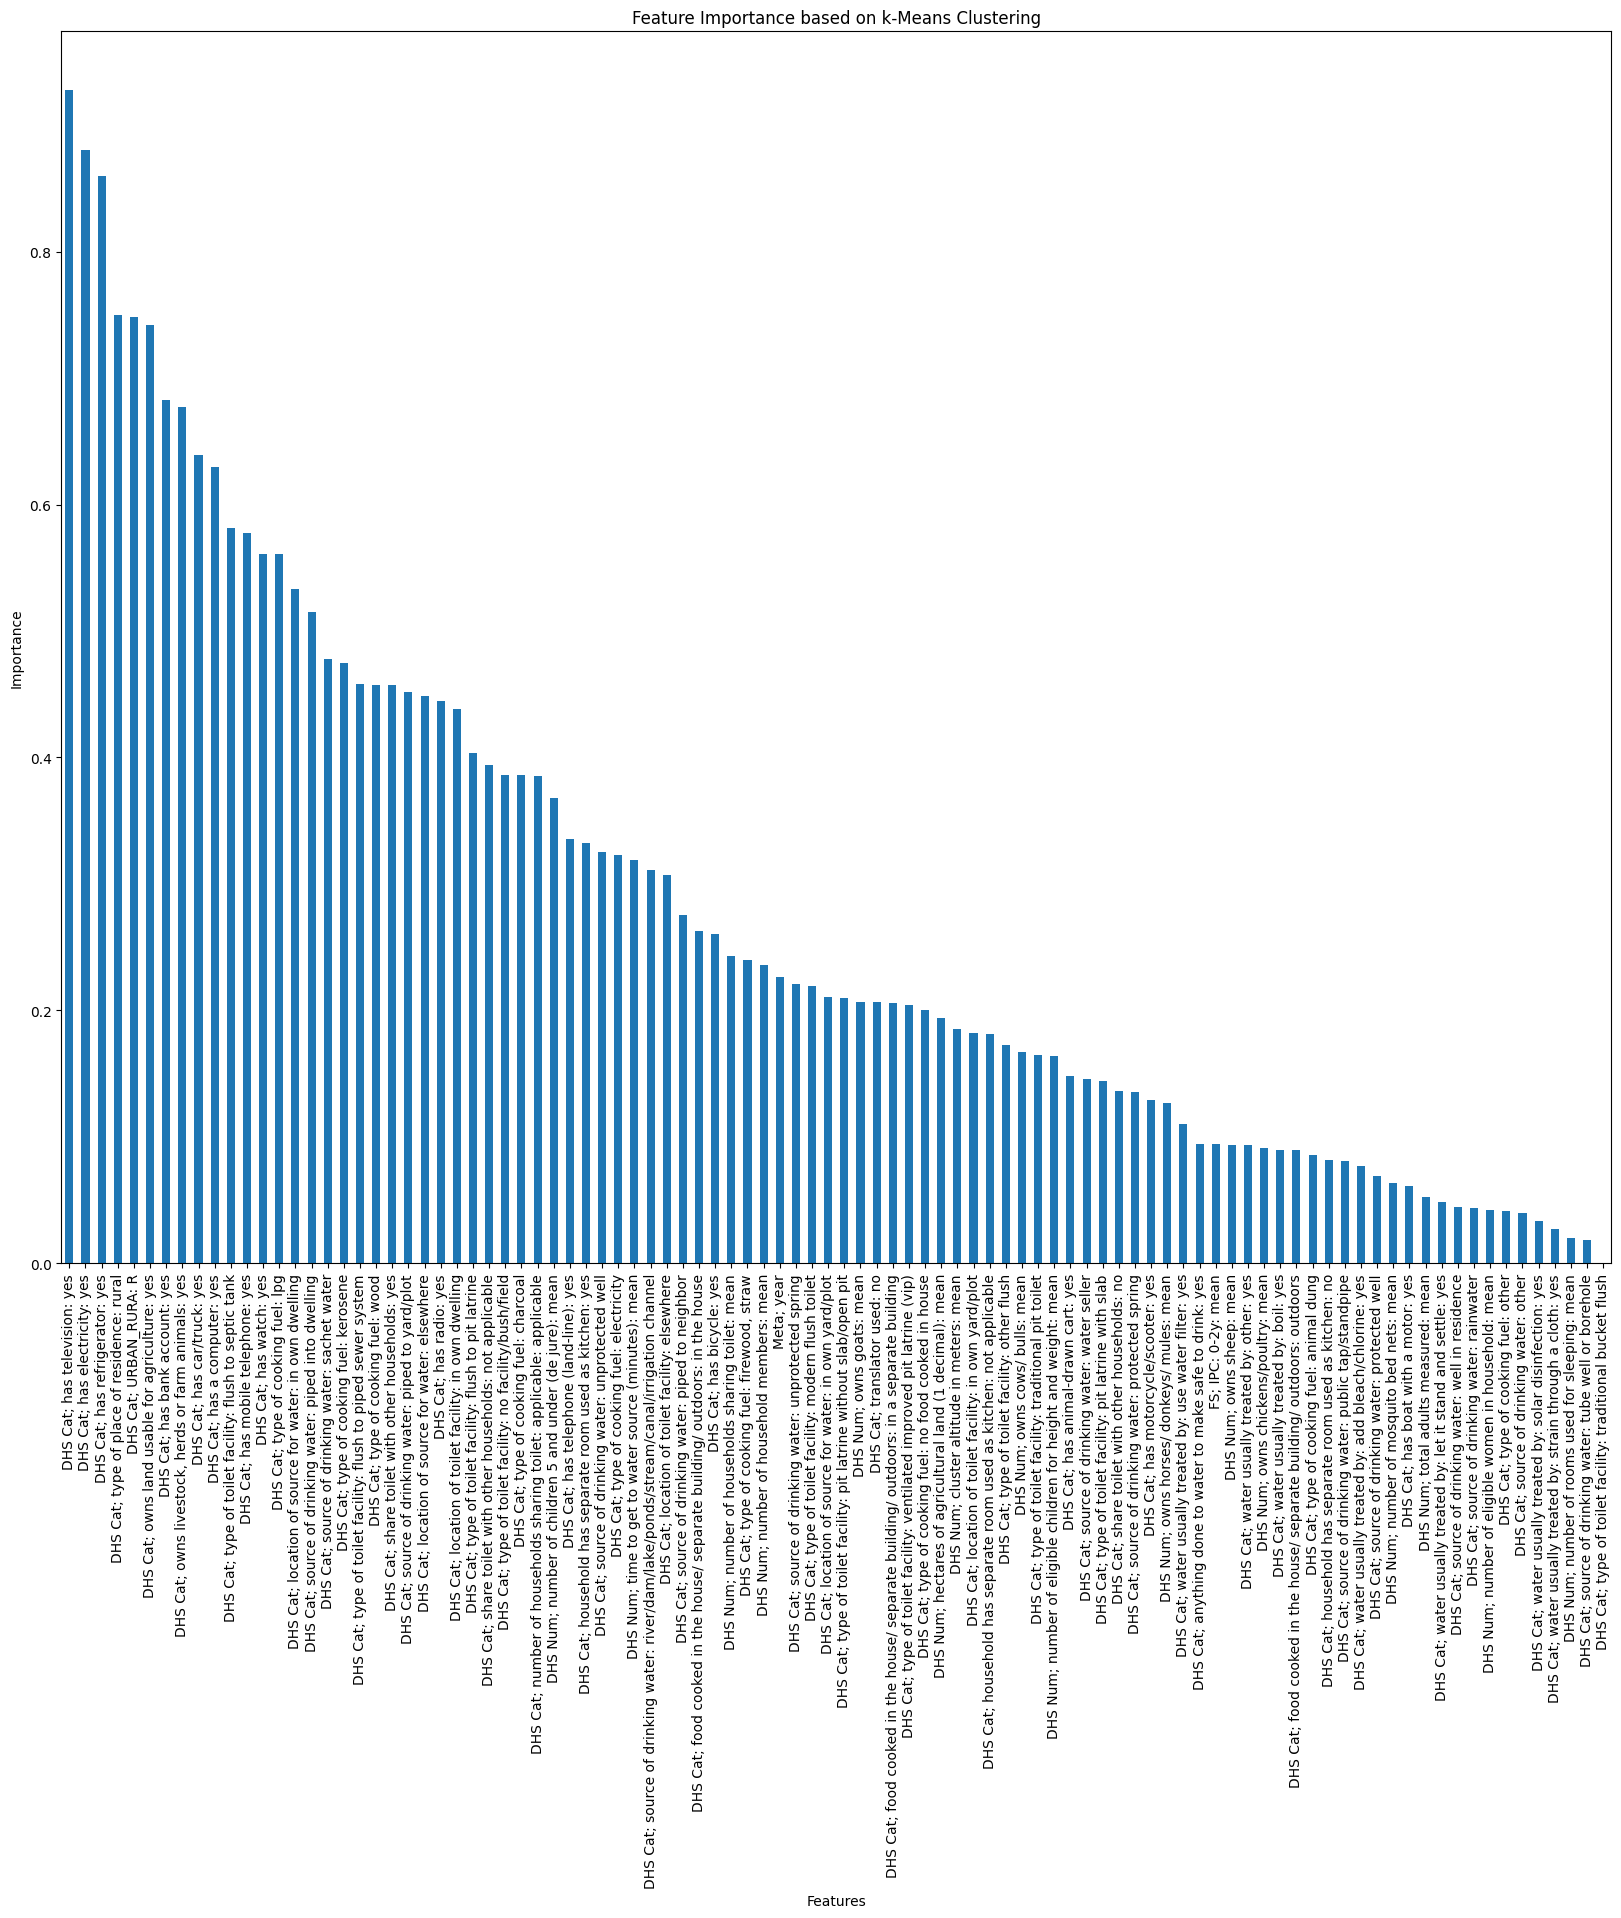

In [14]:
#k-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_df)
#feature importance based on cluster centers
feature_importance = np.std(kmeans.cluster_centers_, axis=0)
scaled_df = pd.DataFrame(scaled_df, columns=numerical_only.columns)

importance_df = pd.DataFrame(feature_importance, index=scaled_df.columns, columns=['Importance'])
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
#feature importance
print('Feature importance based on k-Means clustering:')
print(importance_df)
#feature importance
plt.figure(figsize=(20, 16))
importance_df['Importance'].plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance based on k-Means Clustering')
plt.show()

## What the Values Refer to
### Clustering:

The k-Means algorithm groups the dataset into k clusters based on feature similarity.
Cluster centers (centroids) represent the average position of all the points within each cluster in the feature space.
Feature Importance Calculation:

After fitting the k-Means model, the variability (standard deviation) of the cluster centers is calculated for each feature.
The standard deviation of the cluster centers across clusters for each feature indicates how much that feature varies among the clusters.
Higher variability (standard deviation) means the feature plays a significant role in differentiating between clusters.
Bar Plot Explanation:

### X-axis: Features of the dataset.
Y-axis: Importance score for each feature, derived from the standard deviation of the cluster centers.
Interpretation of the Bar Plot
High Importance Features: Features with higher bars (greater standard deviation in cluster centers) are more important in determining the cluster formation. These features have a more significant impact on the clustering process.
Low Importance Features: Features with shorter bars (lower standard deviation in cluster centers) contribute less to the differentiation between clusters.
### Example Interpretation
Feature A: If Feature A has a high importance score, it means the cluster centers are widely spread in terms of Feature A. This indicates that Feature A is crucial for distinguishing between different clusters.
Feature B: If Feature B has a low importance score, it means the cluster centers are close together in terms of Feature B. This suggests that Feature B is not as important for the clustering process.
This visualization helps in understanding which features are most influential in forming distinct groups within the dataset, providing insights into the underlying structure of the data even without a target variable.